In [16]:
# Importing libraries
import pandas as pd
import numpy as np
import pandas_ta as ta
import matplotlib.pyplot as plt

In [17]:
# Importing historical data
df =pd.read_csv('EURUSD_2010_2024_1H.csv',index_col=0, parse_dates=True)

In [18]:
# If there is interest to test just part of the dataset
# df= df[:5500]
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 86954 entries, 2010-02-08 00:00:00 to 2024-02-09 15:00:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    86954 non-null  float64
 1   high    86954 non-null  float64
 2   low     86954 non-null  float64
 3   close   86954 non-null  float64
 4   volume  86954 non-null  int64  
dtypes: float64(4), int64(1)
memory usage: 4.0 MB


## Features pattern

In [19]:
# Features engineering, patterns, signals or all strategy with output to column (1=long,-1 short)

def calculate_phl(df):
    df = df.copy()
    
    df['phl'] = np.nan
    
    for i in range(2, len(df)):
        first_candle = df.iloc[i-2]
        second_candle = df.iloc[i-1]
        third_candle = df.iloc[i]
        
        if (first_candle['low'] > second_candle['low']) and (second_candle['low'] < third_candle['low']):
            df.loc[df.index[i], 'phl'] = 1
            
        elif (first_candle['high'] < second_candle['high']) and (second_candle['high'] > third_candle['high']):
            df.loc[df.index[i],'phl'] = -1

            
    return df

def calculate_rejection(df):
    df = df.copy()
    df['rejection_candle'] = np.nan
    
    for i in range(2, len(df)):
        # Bullish signal
        if (df.open.iloc[i] < df.close.iloc[i] and
                (df.high.iloc[i] - df.close.iloc[i]) < abs(df.open.iloc[i] - df.close.iloc[i]) / 10 and
                (df.open.iloc[i] - df.low.iloc[i]) > abs(df.open.iloc[i] - df.close.iloc[i]) * 5):
            df.loc[df.index[i], 'rejection_candle'] = 1

        # Bearish signal
        elif (df.open.iloc[i] > df.close.iloc[i] and
              (df.high.iloc[i] - df.open.iloc[i]) > abs(df.open.iloc[i] - df.close.iloc[i]) * 5 and
              (df.close.iloc[i] - df.low.iloc[i]) < abs(df.open.iloc[i] - df.close.iloc[i]) / 10):
            df.loc[df.index[i], 'rejection_candle'] = -1

    return df

def calculate_engulfing(df):
    df = df.copy()
    df['engulfing_candle'] = np.nan
    
    for i in range(2, len(df)):
        # Check for bullish engulfing
        if (df.close.iloc[i] > df.open.iloc[i-1] and
                df.open.iloc[i] < df.close.iloc[i-1] and
                df.close.iloc[i-1] > df.open.iloc[i-1]):
            df.loc[df.index[i], 'engulfing_candle'] = 1

        # Check for bearish engulfing
        elif (df.open.iloc[i] > df.close.iloc[i-1] and
              df.close.iloc[i] < df.open.iloc[i-1] and
              df.close.iloc[i-1] > df.open.iloc[i-1]):
            df.loc[df.index[i], 'engulfing_candle'] = -1

    return df

In [20]:
# Make columns of patterns to df
df = calculate_phl(df)
df = calculate_rejection(df)
df = calculate_engulfing(df)


In [25]:
def testing_pattern(df, column, interval):
    # Initialize counts and lists
    long_up_count = 0
    long_down_count = 0
    long_total_count = 0
    long_distances_ok = []
    long_distances_ko = []
    short_up_count = 0
    short_down_count = 0
    short_total_count = 0
    short_distances_ok = []
    short_distances_ko = []

    # Loop through the DataFrame
    for i in range(1, len(df) - interval):
        # Long signal
        if df[column].iloc[i] == 1:
            long_total_count += 1 
            if df.close.iloc[i + interval] > df.open.iloc[i + 1]:
                long_up_count += 1
                long_distances_ok.append(df.close.iloc[i + interval] - df.open.iloc[i + 1])  # profit
            elif df.close.iloc[i + interval] < df.open.iloc[i + 1]:
                long_down_count += 1
                long_distances_ko.append(df.open.iloc[i + 1] - df.close.iloc[i + interval])  # loss
        # Short signal
        if df[column].iloc[i] == -1:
            short_total_count += 1
            if df.close.iloc[i + interval] < df.open.iloc[i + 1]:
                short_down_count += 1
                short_distances_ok.append(df.open.iloc[i + 1] - df.close.iloc[i + interval])
            elif df.close.iloc[i + interval] > df.open.iloc[i + 1]:
                short_up_count += 1
                short_distances_ko.append(df.close.iloc[i + interval] - df.open.iloc[i + 1])


    # Calculate percentages and mean distances
    long_percentage_win = round((long_up_count / long_total_count) * 100, 2)
    short_percentage_win = round((short_down_count / short_total_count) * 100, 2)

    long_mean_distance_ok = round(np.mean(long_distances_ok) * 10000, 2) if len(long_distances_ok) > 0 else 0
    long_mean_distance_ko = round(np.mean(long_distances_ko) * 10000, 2) if len(long_distances_ko) > 0 else 0
    short_mean_distance_ok = round(np.mean(short_distances_ok) * 10000, 2) if len(short_distances_ok) > 0 else 0
    short_mean_distance_ko = round(np.mean(short_distances_ko) * 10000, 2) if len(short_distances_ko) > 0 else 0

    # Plot histograms
    plt.figure(figsize=(12, 8))

    # Long Patterns
    plt.subplot(2, 2, 1)
    plt.hist(np.array(long_distances_ok) * 10000, bins=30, color='green', alpha=0.7)
    plt.title('Long Pattern - Winning Distances (ok)')
    plt.xlabel('Distance (pips)')
    plt.ylabel('Frequency')

    plt.subplot(2, 2, 2)
    plt.hist(np.array(long_distances_ko) * 10000, bins=30, color='red', alpha=0.7)
    plt.title('Long Pattern - Losing Distances (ko)')
    plt.xlabel('Distance (pips)')
    plt.ylabel('Frequency')

    # Short Patterns
    plt.subplot(2, 2, 3)
    plt.hist(np.array(short_distances_ok) * 10000, bins=30, color='green', alpha=0.7)
    plt.title('Short Pattern - Winning Distances (ok)')
    plt.xlabel('Distance (pips)')
    plt.ylabel('Frequency')

    plt.subplot(2, 2, 4)
    plt.hist(np.array(short_distances_ko) * 10000, bins=30, color='red', alpha=0.7)
    plt.title('Short Pattern - Losing Distances (ko)')
    plt.xlabel('Distance (pips)')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

    # Print results
    return print(f'Long pattern winning in {interval} candles interval is: {long_percentage_win}% \n'
                 f'with average {long_mean_distance_ok} pips return\n'
                 f'Long pattern loss in {interval} candles interval is: {100 - long_percentage_win}% \n'
                 f'with average {long_mean_distance_ko} pips loss \n'
                 f'Short pattern winning in {interval} candles interval is: {short_percentage_win}% \n'
                 f'with average {short_mean_distance_ok} pips return \n'
                 f'Short pattern loss in {interval} candles interval is: {100 - short_percentage_win}% \n'
                 f'with average {short_mean_distance_ko} pips loss \n')


In [26]:
df

,open,high,low,close,volume,phl,rejection_candle,engulfing_candle
time,,,,,,,,
2010-02-08 00:00:00,1.36561,1.36664,1.36307,1.36419,1638,NaN,NaN,NaN
2010-02-08 01:00:00,1.36417,1.36662,1.36329,1.36574,2094,NaN,NaN,NaN
2010-02-08 02:00:00,1.36575,1.36591,1.36404,1.36439,1503,NaN,NaN,NaN
2010-02-08 03:00:00,1.36440,1.36483,1.36210,1.36324,1828,NaN,NaN,NaN
2010-02-08 04:00:00,1.36329,1.36412,1.36268,1.36389,1340,1.0,NaN,NaN
...,...,...,...,...,...,...,...,...
2024-02-09 11:00:00,1.07728,1.07769,1.07661,1.07672,3797,-1.0,NaN,NaN
2024-02-09 12:00:00,1.07669,1.07702,1.07622,1.07668,2799,NaN,NaN,NaN
2024-02-09 13:00:00,1.07668,1.07733,1.07636,1.07717,2624,1.0,NaN,NaN


In [27]:
# Combinating patterns
#df['phlrej'] = np.where((df['rejection_candle'] == 1) & (df['phl'] == 1),1,0 ) 
#df['phlrej'] = np.where((df['rejection_candle'] == -1) & (df['phl'] == -1),-1,df['phlrej'] ) 

In [28]:
# Value of patterns
df.engulfing_candle.value_counts()

engulfing_candle
 1.0    10237
-1.0     3218
Name: count, dtype: int64

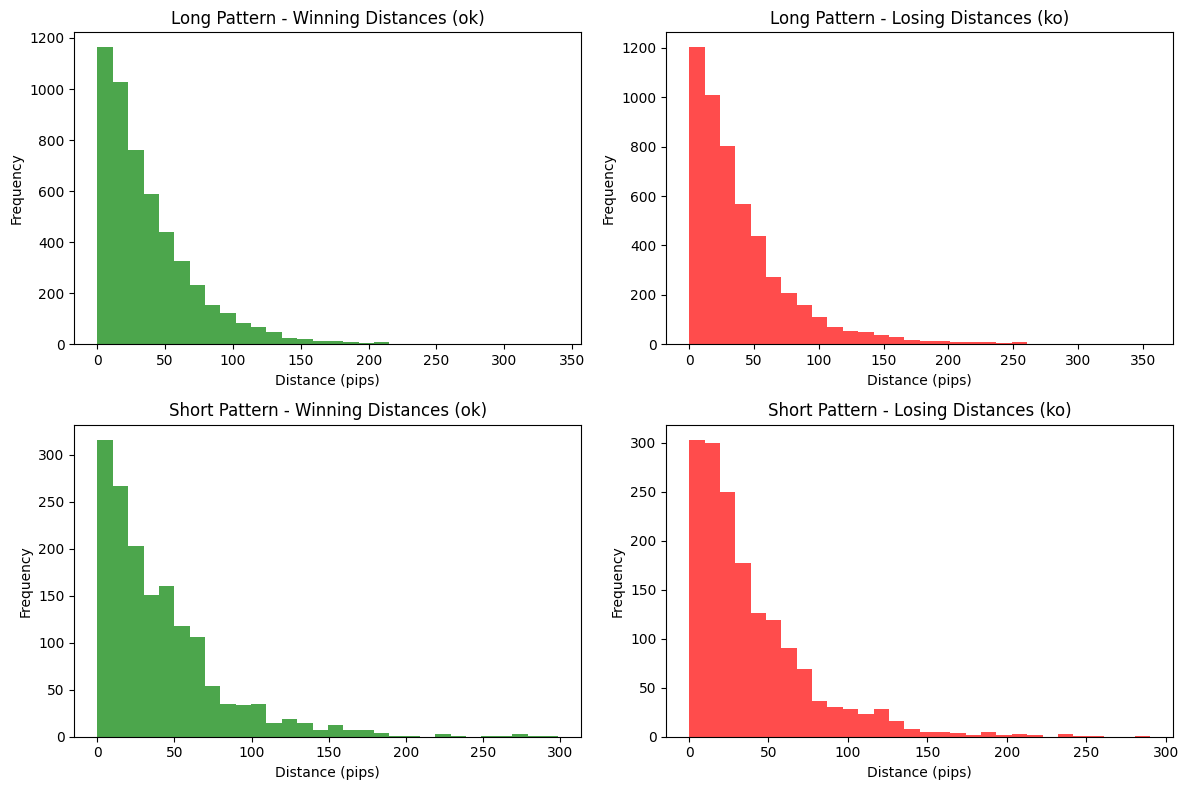

Long pattern winning in 15 candles interval is: 50.04% 
with average 38.11 pips return
Long pattern loss in 15 candles interval is: 49.96% 
with average 39.74 pips loss 
Short pattern winning in 15 candles interval is: 49.07% 
with average 41.47 pips return 
Short pattern loss in 15 candles interval is: 50.93% 
with average 39.37 pips loss 



In [29]:
# Single testing
testing_pattern(df,'engulfing_candle',15)

In [ ]:
# Multiple testing patterns and intervals
columns = ['rejection_candle', 'engulfing_candle', 'phl']
intervals = [5,10,15]

for column in columns:
    for interval in intervals:
        print(f'Testing {column} with interval {interval}:')
        testing_pattern(df, column, interval)
        print('\n')